In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [2]:
data = pd.read_csv('../dataset/CC Data 2.csv')
data.head(5)

,Customer Age,Gender,Education Level,Marital Status,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income
0,45,M,High School,Married,39,12691,1144,42,60000,80000
1,49,F,Graduate,Single,44,8256,1291,33,0,40000
2,51,M,Graduate,Married,36,3418,1887,20,80000,120000
3,40,F,High School,Unknown,34,3313,1171,20,0,40000
4,40,M,Uneducated,Married,21,4716,816,28,60000,80000


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
columns_to_encode = ['Gender', 'Education Level', 'Marital Status']

for column in columns_to_encode:
    data[column] = le.fit_transform(data[column])

data

,Customer Age,Gender,Education Level,Marital Status,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income
0,45,1,3,1,39,12691,1144,42,60000,80000
1,49,0,2,2,44,8256,1291,33,0,40000
2,51,1,2,1,36,3418,1887,20,80000,120000
3,40,0,3,3,34,3313,1171,20,0,40000
4,40,1,5,1,21,4716,816,28,60000,80000
...,...,...,...,...,...,...,...,...,...,...
10122,50,1,2,2,40,4003,15476,117,40000,60000
10123,41,1,6,0,25,4277,8764,69,40000,60000
10124,44,0,3,1,36,5409,10291,60,0,40000
10125,30,1,2,3,36,5281,8395,62,40000,60000


In [4]:
# Functions for EDA
def remove_duplicates(df):
    if(any(df.duplicated())):
        return df.drop_duplicates(keep='first')
    
    print('No duplicates')
    return df

def count_nulls(df):
    # Count the number of rows with null values
    num_rows_with_nulls = df.isnull().any(axis=1).sum()
    
    # Count the number of null values in each column
    null_counts = df.isnull().sum()
    
    return (num_rows_with_nulls, null_counts)


def plot_correlation(df, column):
    # Drop rows with missing values in the specified column
    df = df.dropna(subset=[column])
    
    # Calculate the correlation coefficients
    corr = df.corr()[[column]]
    
    # Create a bar plot
    ax = sns.barplot(data=corr, x=column, y=corr.index, orient='h')
    ax.set_title(f'Correlation between {column} and other columns')
    
    # Show the plot
    plt.show()

In [5]:
# Check for duplicates and null values in columns
data = remove_duplicates(df=data)
count_nulls(data)

No duplicates


(0,
 Customer Age         0
 Gender               0
 Education Level      0
 Marital Status       0
 Months on book       0
 Credit Limit         0
 Total Trans Amt      0
 Total Trans Count    0
 Minimum income       0
 Max income           0
 dtype: int64)

In [6]:
# Retrieve the rows will null value in their columns.
# The easy way out will be to remove those rows but we will look at how we can fill in the missing values.
null_rows = data[data.isnull().any(axis=1)]
null_rows.head(5)

,Customer Age,Gender,Education Level,Marital Status,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income


In [7]:
def find_outliers(df):
    outliers = {}
    fig, axs = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 5*len(df.columns)))
    
    # Loop through each column in the DataFrame
    for i, col in enumerate(df.columns):
        # Check if the column is numeric
        if df[col].dtype in ["int64", "float64"]:
            # Calculate the IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Calculate the lower and upper bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Find the outlier indices
            outlier_indexes = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
            
            # Add the outlier information to the dictionary
            outliers[col] = {
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outlier_indexes': outlier_indexes,
                'outlier_values': df.loc[outlier_indexes, col].tolist()
            }
            
            # Plot the boxplot
            axs[i].boxplot(df[col], vert=False)
            axs[i].set_title(col)
    
    plt.show()
    return outliers


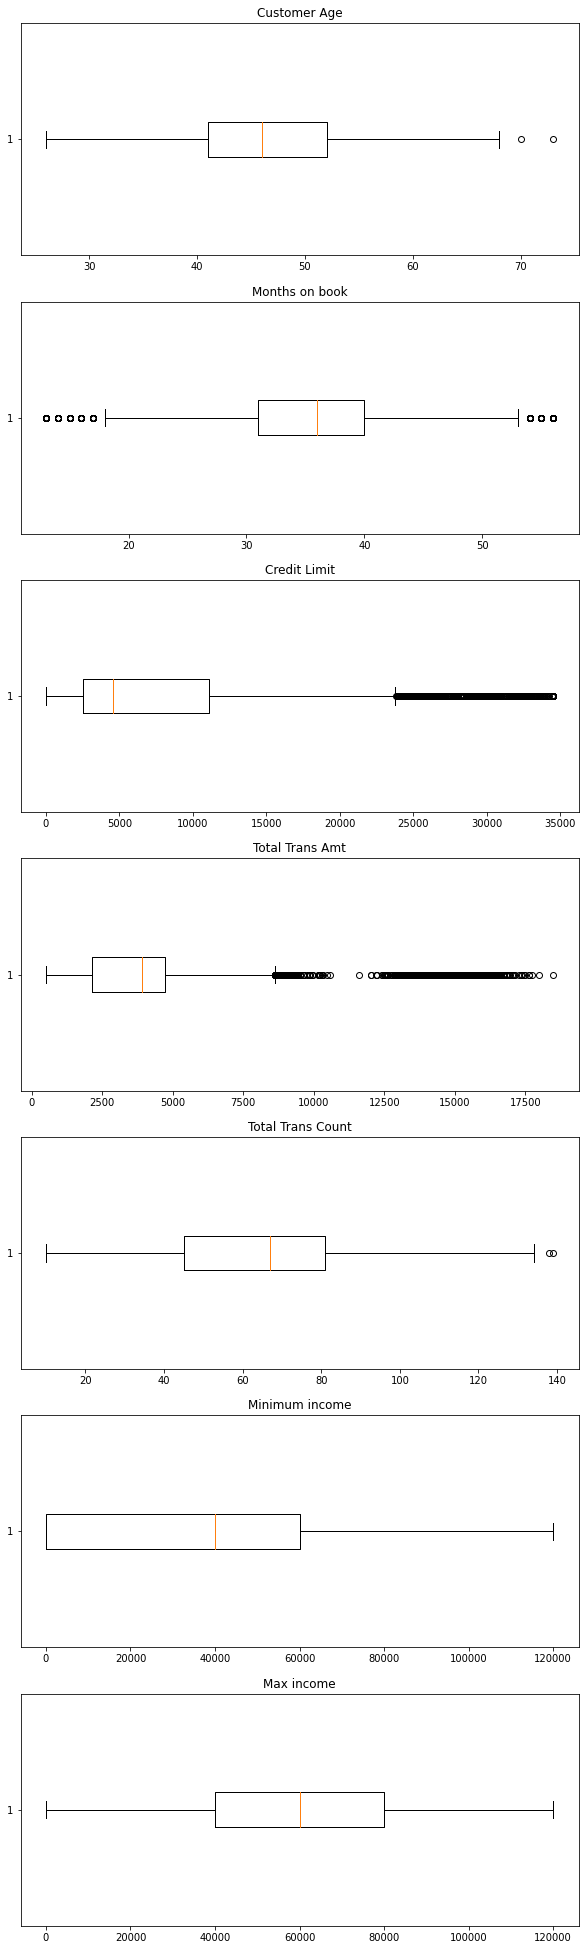

Column: Customer Age
Outlier range: < 24.5 or > 68.5
Outlier values: [73, 70]
Column: Months on book
Outlier range: < 17.5 or > 53.5
Outlier values: [54, 56, 56, 56, 54, 56, 56, 56, 54, 55, 56, 56, 54, 54, 56, 56, 56, 56, 13, 13, 56, 56, 13, 56, 56, 56, 15, 56, 17, 13, 54, 54, 13, 56, 54, 13, 54, 55, 54, 17, 17, 56, 13, 17, 16, 15, 16, 56, 56, 13, 56, 56, 56, 17, 14, 13, 13, 56, 54, 54, 15, 56, 16, 56, 17, 17, 14, 17, 55, 55, 14, 13, 14, 54, 54, 13, 15, 13, 13, 15, 13, 13, 13, 17, 55, 56, 56, 13, 15, 55, 13, 13, 55, 13, 15, 16, 56, 13, 56, 16, 54, 16, 55, 55, 16, 56, 56, 17, 54, 13, 13, 17, 14, 56, 15, 13, 13, 54, 13, 17, 13, 14, 13, 13, 56, 15, 15, 16, 13, 55, 56, 17, 17, 15, 17, 15, 13, 56, 56, 13, 54, 56, 55, 15, 56, 15, 56, 16, 17, 13, 15, 13, 56, 56, 56, 13, 56, 56, 17, 13, 56, 16, 55, 14, 14, 16, 54, 17, 17, 13, 17, 14, 14, 14, 54, 15, 56, 55, 13, 14, 17, 17, 56, 56, 13, 15, 56, 13, 56, 54, 15, 55, 54, 17, 56, 17, 56, 54, 54, 13, 13, 55, 54, 55, 56, 16, 56, 13, 56, 55, 56, 56, 56

In [8]:
outliers = find_outliers(data.drop(columns=columns_to_encode))
for col, info in outliers.items():
    print(f'Column: {col}')
    print(f'Outlier range: < {info["lower_bound"]} or > {info["upper_bound"]}')
    # print(f'Outlier rows: {info["outlier_indexes"]}')
    print(f'Outlier values: {info["outlier_values"]}')

#### Observations 
 All the columns have a ton of outliers, removing them is not going to help 

# EDA

In [9]:
# Now that we sort of clean the dataset, lets do some exploration
data.describe()

,Customer Age,Gender,Education Level,Marital Status,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,0.470919,3.096574,1.463415,35.928409,8559.946381,4404.086304,64.858695,36117.310161,62549.619828
std,8.016814,0.499178,1.834812,0.737808,7.986416,9150.975221,3397.129254,23.472570,38480.075870,37270.290345
min,26.000000,0.000000,0.000000,0.000000,13.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,0.000000,2.000000,1.000000,31.000000,2555.000000,2155.500000,45.000000,0.000000,40000.000000
50%,46.000000,0.000000,3.000000,1.000000,36.000000,4549.000000,3899.000000,67.000000,40000.000000,60000.000000
75%,52.000000,1.000000,5.000000,2.000000,40.000000,11067.500000,4741.000000,81.000000,60000.000000,80000.000000
max,73.000000,1.000000,6.000000,3.000000,56.000000,34516.000000,18484.000000,139.000000,120000.000000,120000.000000


In [10]:
def plot_histograms(df, ncols=4):
    # Calculate the number of rows to use in the layout of the plots
    nrows = (len(df.columns) + ncols - 1) // ncols
    
    # Create a figure and axes
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    
    # Flatten the axes array
    axes = axes.flatten()
    
    # Create a histogram for each column
    for i, column in enumerate(df.columns):
        ax = axes[i]
        sns.distplot(df[column].dropna(), ax=ax, hist=True, kde=True)
        #ax.set_title(column)
    
    # Show the plots
    plt.show()

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\2271981933.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna(), ax=ax, hist=True, kde=True)
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\2271981933.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna()

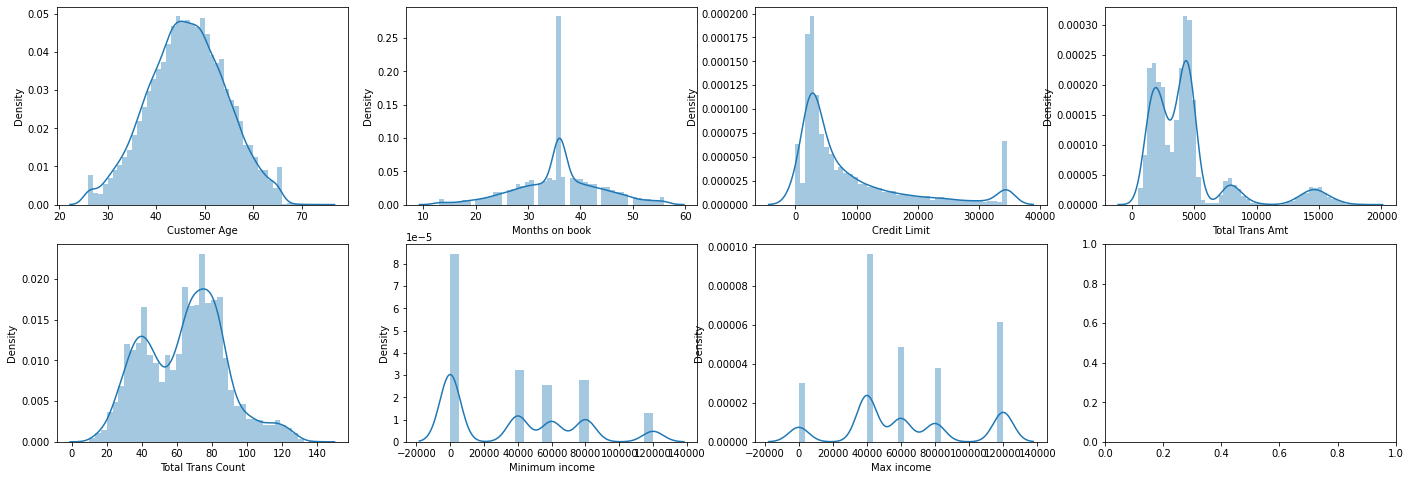

In [11]:
plot_histograms(data.drop(columns=columns_to_encode))

In [12]:
# Lets look at correlation
def plot_corr_heatmap(df, figsize=(15, 8)):
    # Create a figure with the specified size
    plt.figure(figsize=figsize)
    
    # Calculate the correlation matrix
    corr = df.corr()
    
    # Create a heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()

def plot_corr_scatter_matrix(df):
    # Create a pairplot
    sns.pairplot(df)
    
    # Show the plot
    plt.show()


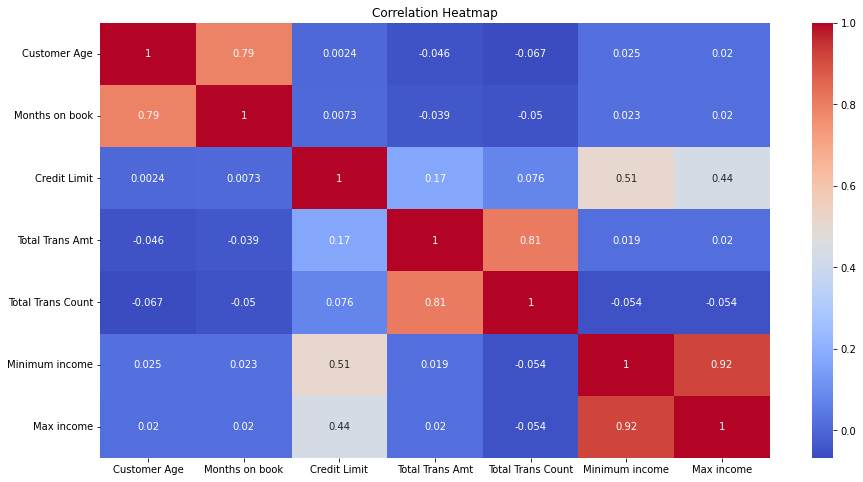

In [13]:
plot_corr_heatmap(data.drop(columns=columns_to_encode))

In [14]:
# plot_corr_scatter_matrix(data.drop(columns=columns_to_encode))

In [15]:
def standard_scale(df):
   
    scaler = StandardScaler()
    
    # Fit the scaler to the data
    scaler.fit(df)
    
    # Transform the data
    scaled_data = scaler.transform(df)
    
    
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    
    return scaled_df

In [16]:
# scaler = StandardScaler()
# columns_to_scale = ['Customer Age', 'Months on book', 'Credit Limit', 'Total Trans Amt', 'Total Trans Count', 'Minimum income', 'Max income']
# standard_scaled_data = data.copy()
# standard_scaled_data[columns_to_scale] = scaler.fit_transform(standard_scaled_data[columns_to_scale])
standard_scaled_data = standard_scale(data)

# PCA

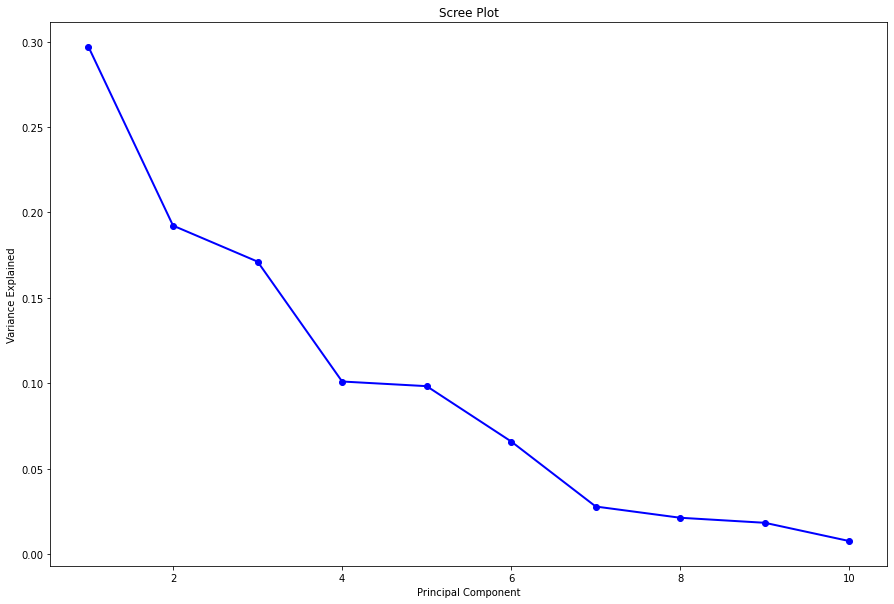

In [17]:
# Scree Plot to determine PCA n components
# Assuming that 'data' is your dataset
pca = PCA(random_state=24).fit(standard_scaled_data)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.savefig('../visualisations/K-means/ScreePlot for Dataset 2.png')  
plt.show()

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=24)
transformed_scaled_data = pca.fit_transform(standard_scaled_data )

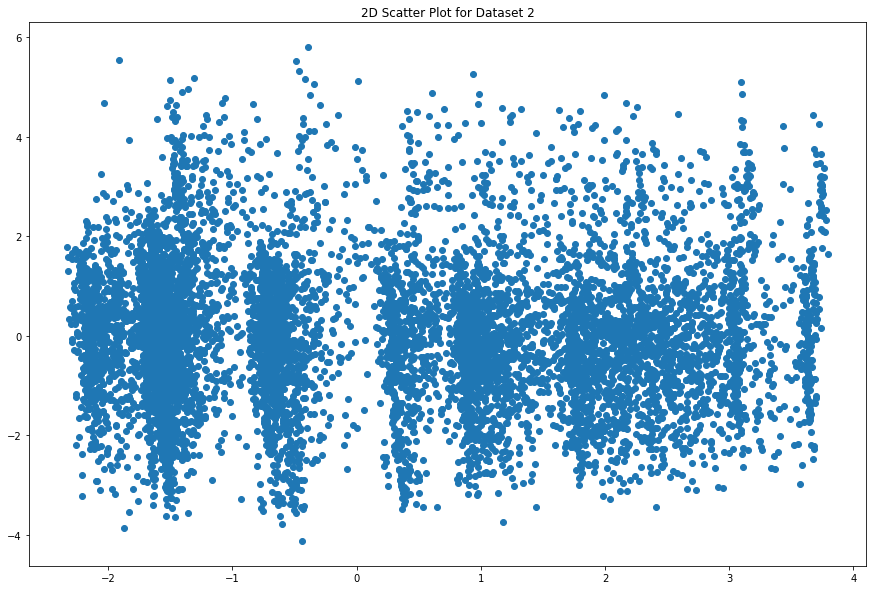

In [19]:
plt.figure(figsize=(15,10))
plt.scatter(transformed_scaled_data[:, 0], transformed_scaled_data[:, 1])
plt.title('2D Scatter Plot for Dataset 2')  # Add your title
plt.savefig('../visualisations/K-means/2D SCatter Plot for Dataset 2.png')  
plt.show()
plt.show()

# K-means Clustering

In [20]:
def kmeans_elbow_method(data, max_k=30, figsize=(15, 8)):
    ssd = []
    silhouette_scores = []
    plt.figure(figsize=figsize)
    # Loop through different values of k
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        
        # Fit the k-means clustering model to the data
        kmeans.fit(data)
        
        # Calculate the sum of squared distances
        ssd.append(kmeans.inertia_)
        
        # Calculate the average silhouette score
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Sum of squared distances', color='b')
    ax1.plot(range(2, max_k+1), ssd, 'bo-')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette score', color='r')
    ax2.plot(range(2, max_k+1), silhouette_scores, 'ro-')
    
    fig.tight_layout()
    
    plt.savefig('../visualisations/K-means/dataset2_elbow_curve.png')
    plt.show()

c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

<Figure size 1080x576 with 0 Axes>

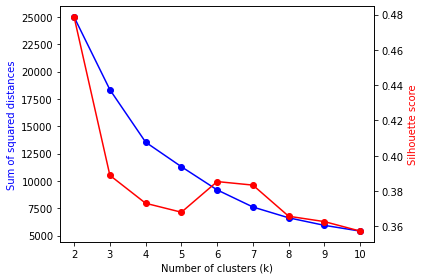

In [21]:
kmeans_elbow_method(transformed_scaled_data, max_k=10)

c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


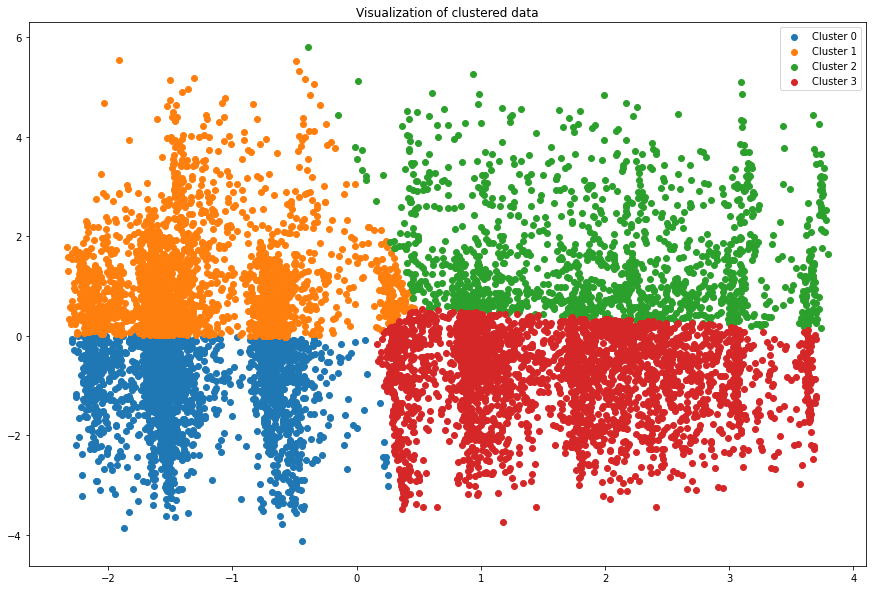

In [22]:
# Number of cluster for K-means to be 4 or 5
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_scaled_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_scaled_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_scaled_data[cluster_labels == i, 0], transformed_scaled_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids

#plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered data')
plt.savefig('../visualisations/K-means/dataset2_cluster.png')
plt.show()

In [23]:
kmeans_data = data.copy()
kmeans_data['kmeans_cluster'] = kmeans.labels_

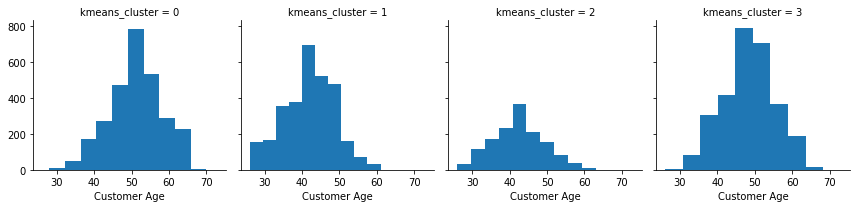

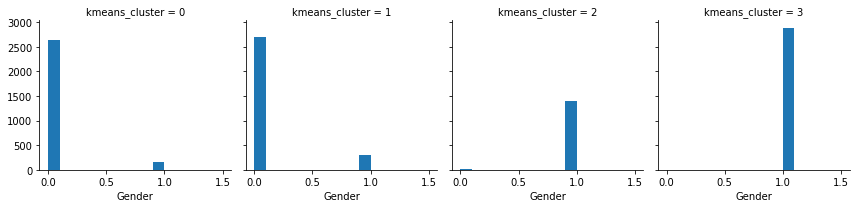

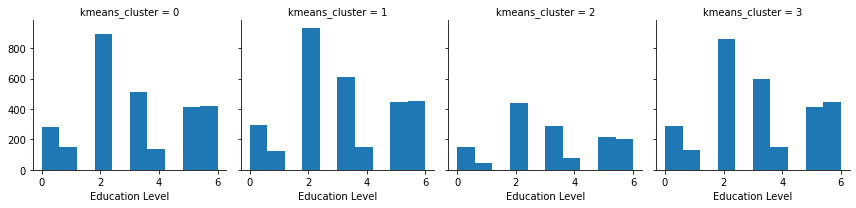

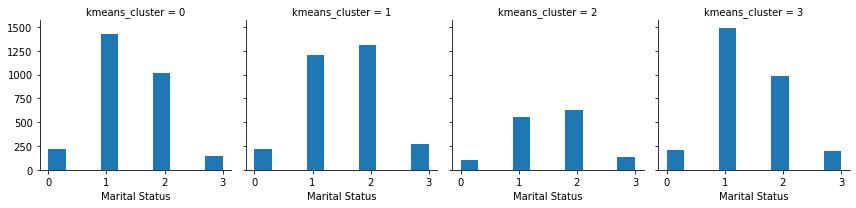

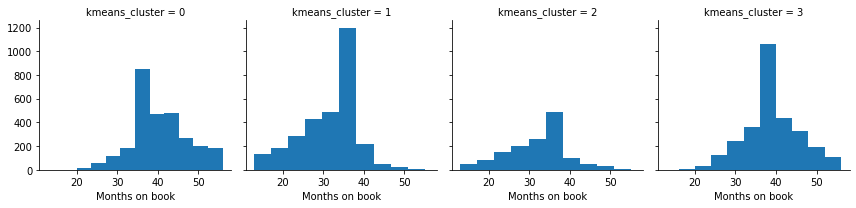

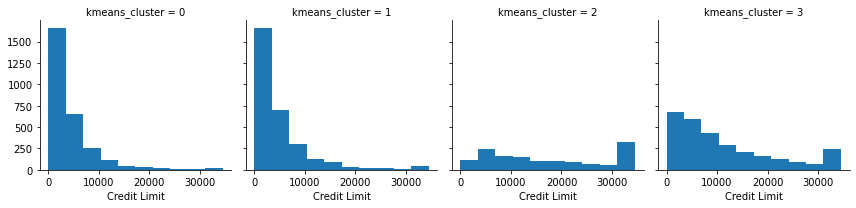

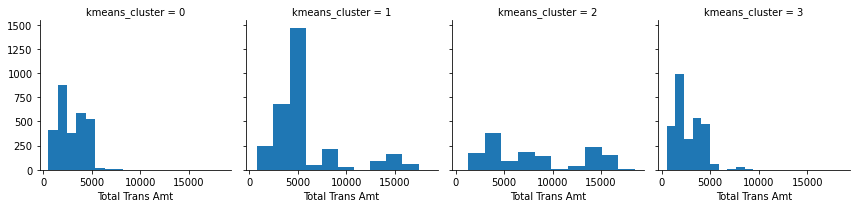

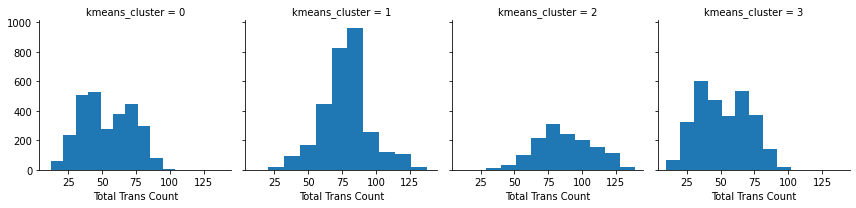

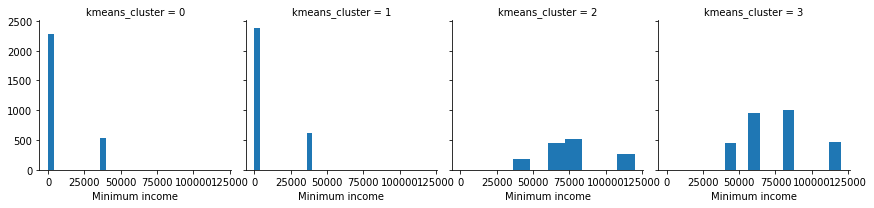

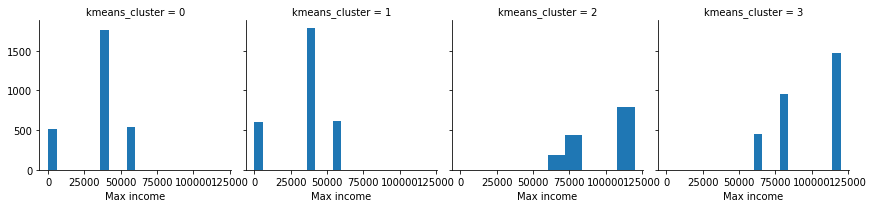

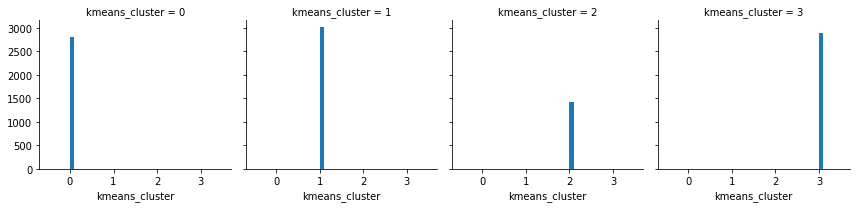

In [24]:
for c in kmeans_data:
    grid= sns.FacetGrid(kmeans_data, col='kmeans_cluster')
    grid.map(plt.hist, c)

In [25]:
cluster_kmeans = kmeans_data.groupby('kmeans_cluster').mean().T
cm = sns.light_palette("blue", as_cmap=True)
cluster_kmeans = cluster_kmeans.style.background_gradient(cmap=cm)
cluster_kmeans

kmeans_cluster,0,1,2,3
Customer Age,51.094916,41.722924,42.358557,48.419377
Gender,0.059723,0.101329,0.994342,1.000000
Education Level,3.065766,3.102990,3.105375,3.115571
Marital Status,1.387131,1.542857,1.560113,1.407612
Months on book,40.392464,31.496678,31.938472,38.151211
Credit Limit,4476.151795,5252.127575,17494.992221,11608.421799
Total Trans Amt,2952.447209,5552.603322,8128.866337,2798.406574
Total Trans Count,53.542837,77.780066,86.565771,51.794464
Minimum income,7593.316744,8239.202658,75813.295615,73494.809689
Max income,36487.735514,36186.046512,99519.094767,97287.197232


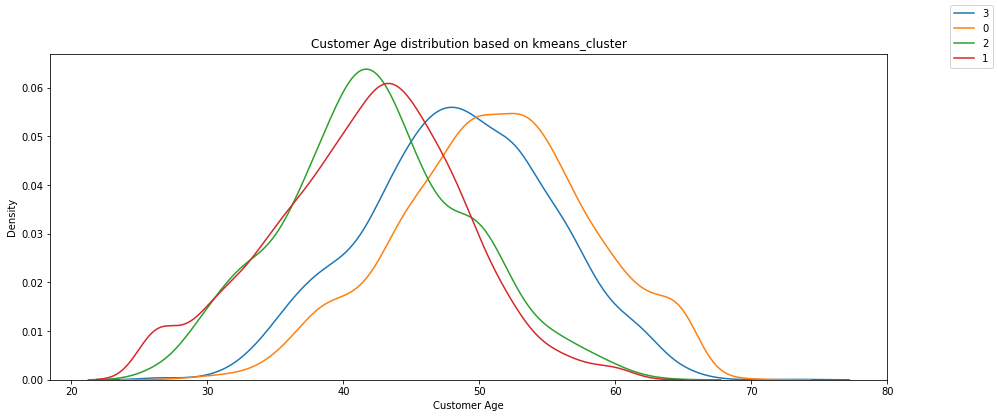

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])


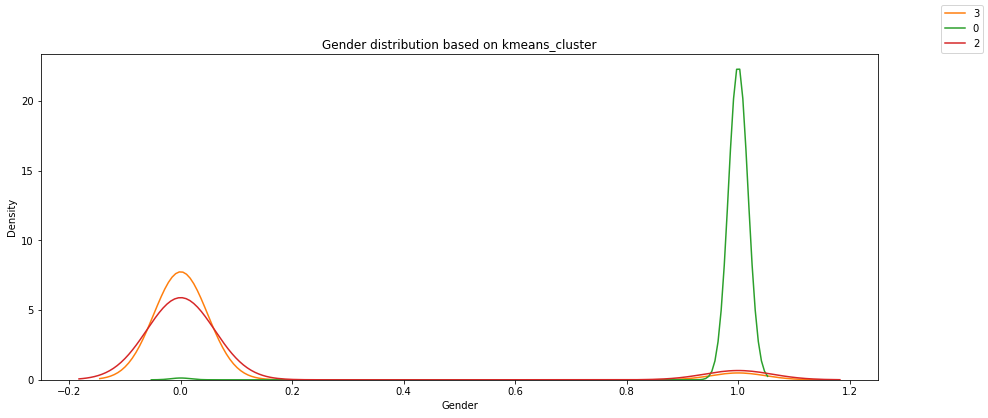

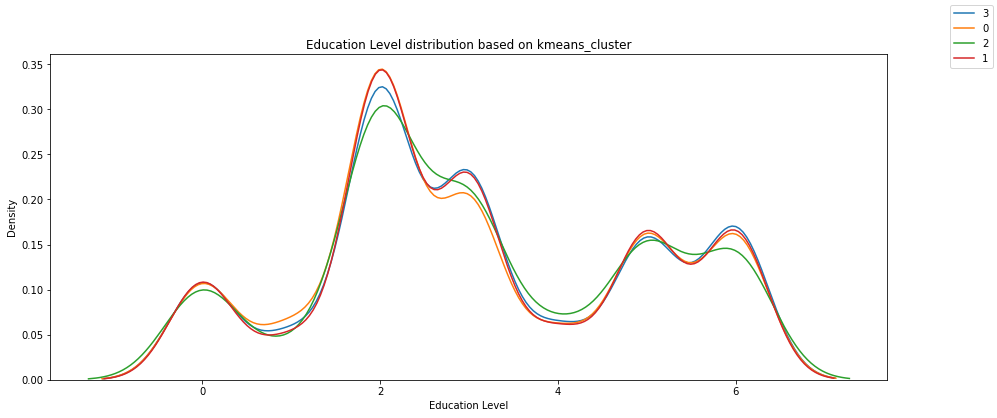

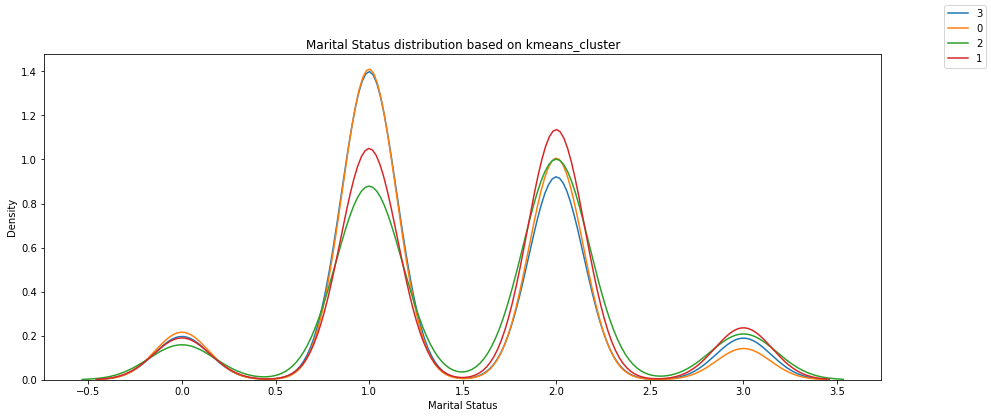

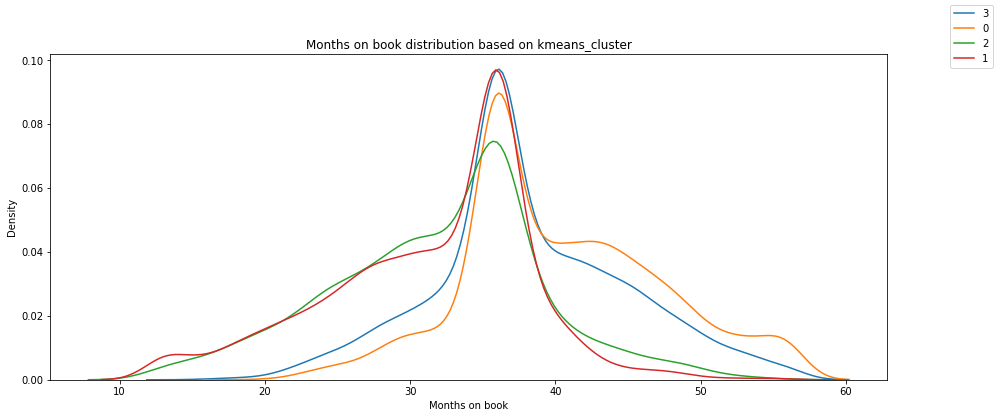

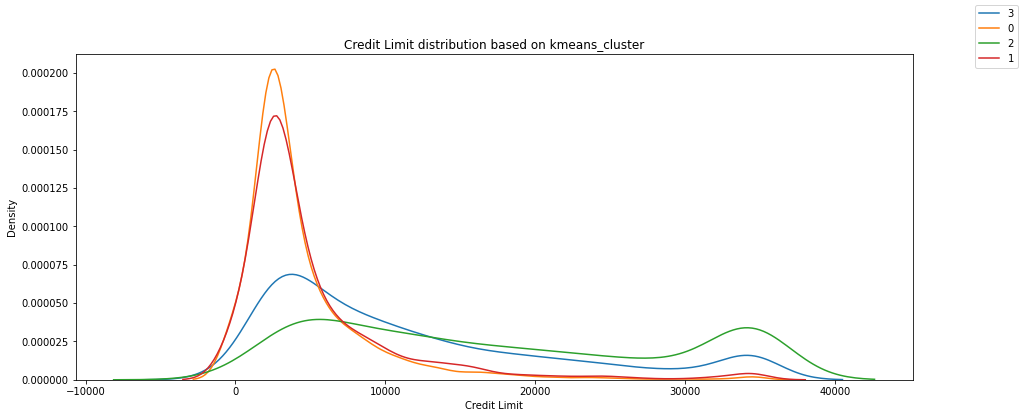

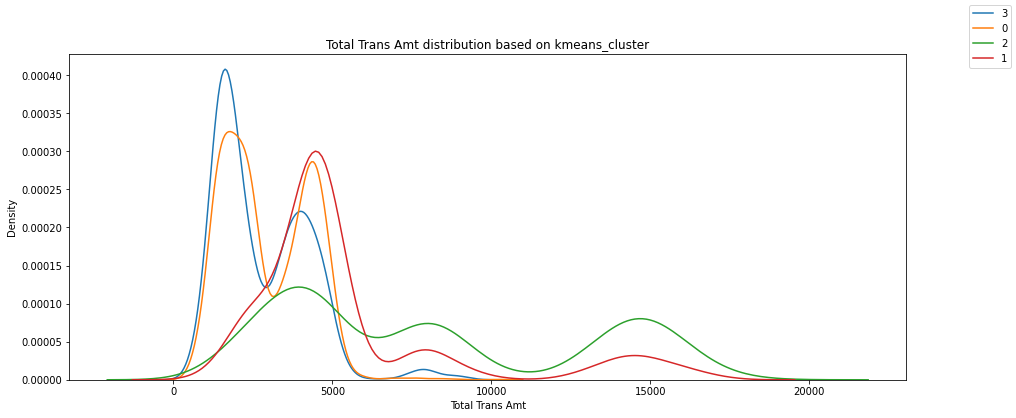

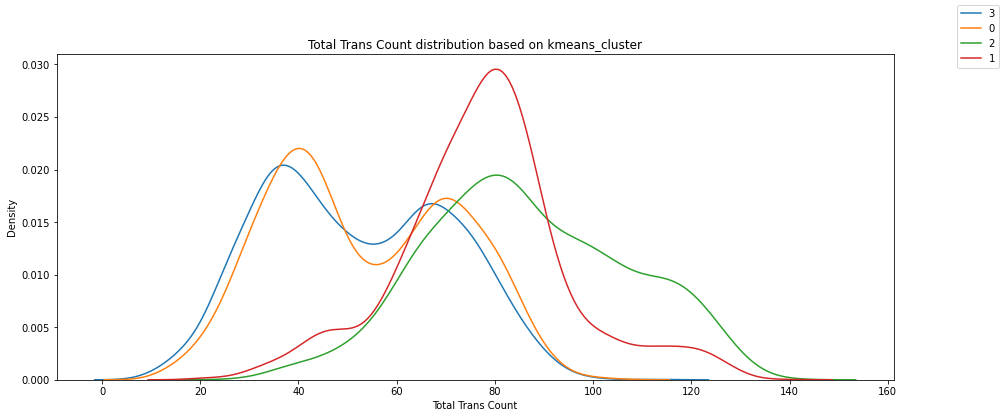

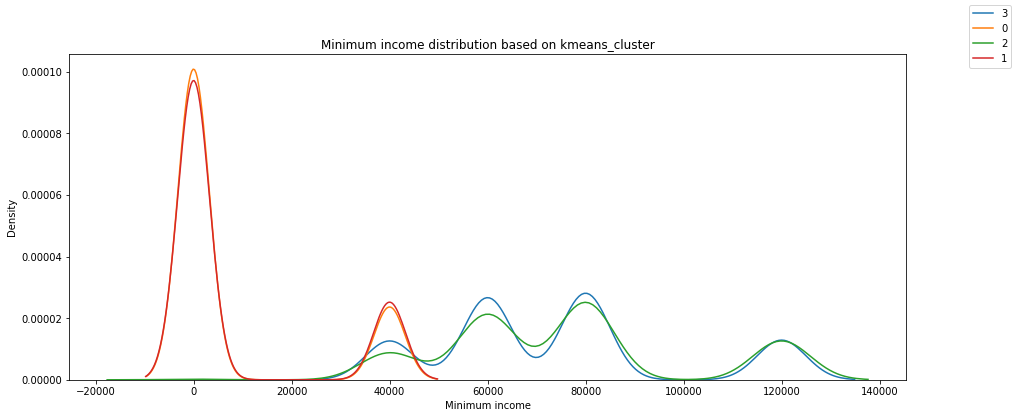

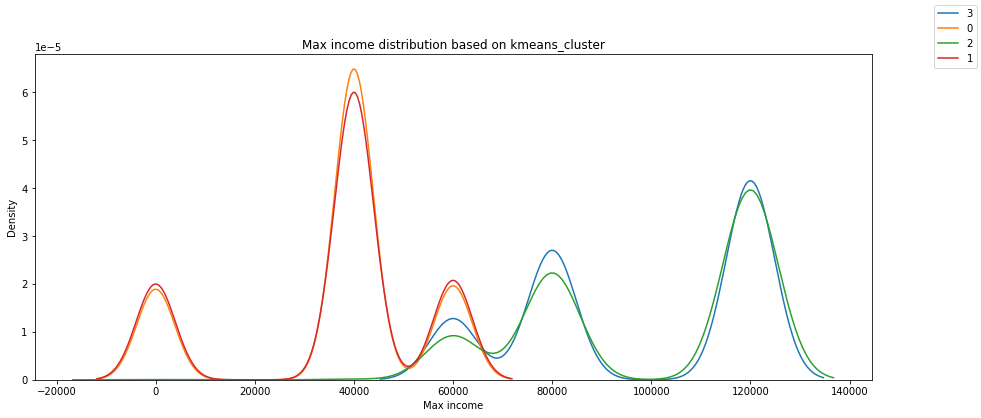

In [26]:
def plot_num_cat(data, feature, target, figsize=None):
    fig = plt.figure(figsize=(15,6))

    for value in data[target].unique():
        sns.kdeplot(data[data[target]==value][feature])

    fig.legend(labels=data[target].unique())
    plt.title('{} distribution based on {}'.format(feature, target))
    plt.show()


for feature in kmeans_data:
    if(feature == 'kmeans_cluster'):
        continue
    plot_num_cat(kmeans_data, feature, 'kmeans_cluster')


c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

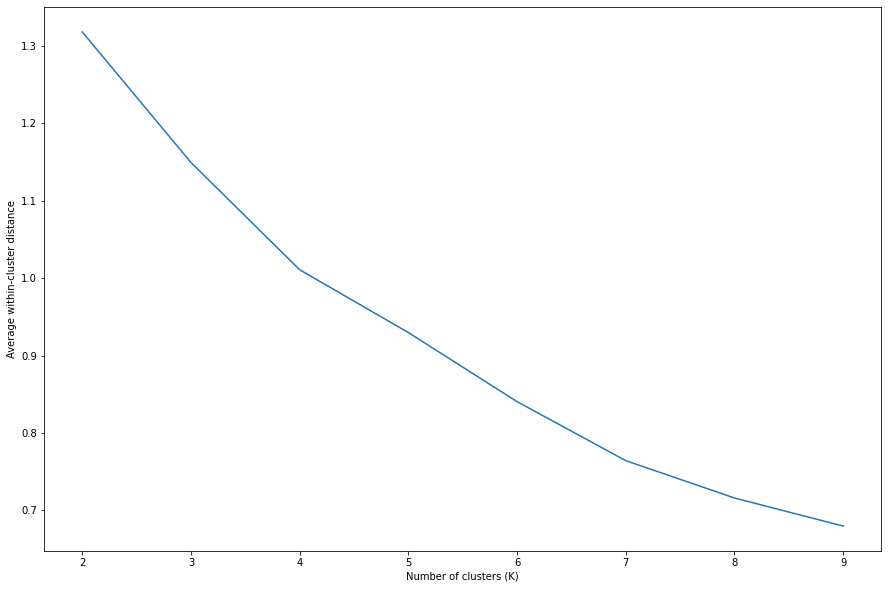

In [27]:
# Evaluation of K-means 
"""
The average within cluster distance is a measure used to evaluate the performance of the K-means algorithm.
It calculates the average distance between the centroid and all the points in the cluster. The idea is that points in the same cluster.
The idea is that points in the same cluster should be close to the centroid, 
so a lower average within clustrer distance indicats better clustering performance
"""

# Calculate within cluster distance

K_values = range(2, 10)  # replace with your desired range of K values
avg_distances = []
plt.figure(figsize=(15,10))
for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(transformed_scaled_data)

    clusters = kmeans.labels_
    centroids = kmeans.cluster_centers_

    total_distance = 0
    total_points = 0

    for i in range(K):
        cluster_points = transformed_scaled_data[clusters == i]
        #print(cluster_points)
        centroid = centroids[i]
        
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        total_distance += np.sum(distances)
        total_points += len(cluster_points)

    avg_within_cluster_distance = total_distance / total_points

    avg_distances.append(avg_within_cluster_distance)

# for index, dist in enumerate(avg_distances):
#     index+=2
#     print(f'(Kmeans) within cluster distance for K = {index}: {dist}')

# Now you can plot the average within-cluster distance for each K value
plt.plot(K_values, avg_distances)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average within-cluster distance')
plt.savefig("../visualisations/K-means/dataset2_averge_within_cluster_distance.png")
plt.show()

In [28]:
from scipy.spatial import distance
def average_cluster_distance(labels, data):
    unique_labels = np.unique(labels)
    avg_distances = []

    for label in unique_labels:
        if label != -1:  # Ignore noise points
            cluster_points = data[labels == label]
            pairwise_distances = distance.pdist(cluster_points)
            avg_distance = np.mean(pairwise_distances)
            avg_distances.append(avg_distance)

    return avg_distances

Kmeans_avg_distance = average_cluster_distance(cluster_labels , transformed_scaled_data)

for index, dist in enumerate(Kmeans_avg_distance):
    print(f'(Kmeans) Average distance between members of Cluster {index}: {dist}')

(Kmeans) Average distance between members of Cluster 0: 1.1411832544401284
(Kmeans) Average distance between members of Cluster 1: 1.2659102823721198
(Kmeans) Average distance between members of Cluster 2: 1.8247725468408358
(Kmeans) Average distance between members of Cluster 3: 1.57184901871163


In [29]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index


Kmeans_silhouette, Kmeans_davies_bouldin, Kmeans_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_scaled_data)

print(f'Kmeans Silhouette score: {Kmeans_silhouette}')
print(f'Kmeans Davies-Bouldin Index: {Kmeans_davies_bouldin}')
print(f'Kmeans Calinski-Harabasz Index: {Kmeans_calinski_harabasz}')

Kmeans Silhouette score: 0.36272147795085247
Kmeans Davies-Bouldin Index: 0.8513215847488875
Kmeans Calinski-Harabasz Index: 9278.02497392764


# DBSCAN

In [30]:
def find_best_eps(data, min_samples):
    # Step 1: Calculate the average distance between each point in the data set and its K nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Get the distance to the furthest neighbor (last column of sorted distances)
    k_distances = distances[:, -1]

    # Step 2: Sort distance values by ascending order and plot the K-distance graph
    sorted_distances = np.sort(k_distances)

    # Step 3: Find the elbow point in the graph and use the corresponding distance as Epsilon
    diffs = np.diff(sorted_distances)

    max_diff_index = np.argmax(diffs)
    plt.figure(figsize=(15,10))
    plt.plot(sorted_distances)
    plt.xlabel('Data point index')
    plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
    plt.yticks(np.arange(min(sorted_distances), max(sorted_distances)+1, 0.1))

    #plt.plot(max_diff_index, sorted_distances[max_diff_index], 'ro')

    plt.savefig("../visualisations/dbscan/dataset2_best_eps.png")
    plt.show()
    



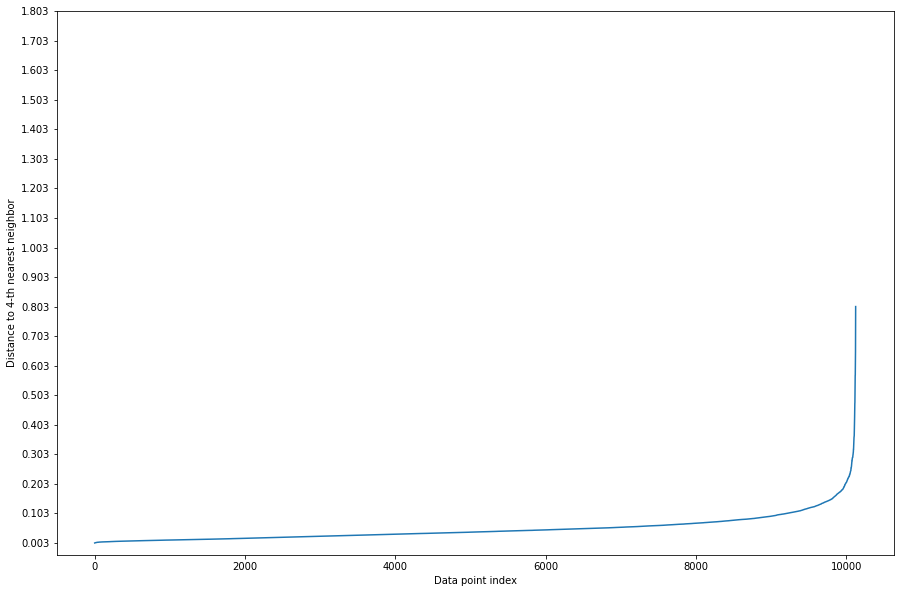

In [31]:
eps = find_best_eps(transformed_scaled_data, min_samples=4)

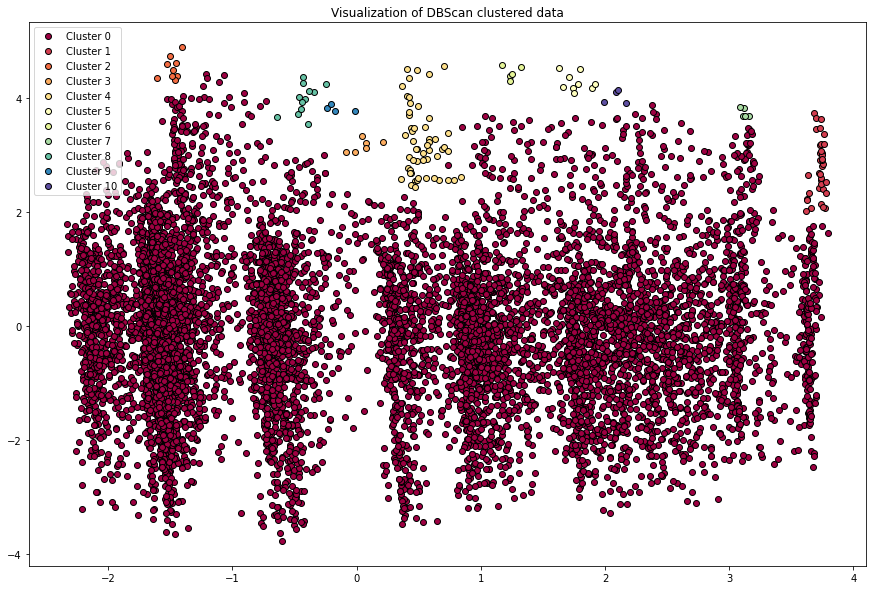

In [32]:
# Best epsilon is determine by the max curvature, which seems to be between 0 and 1 , i will choose 0.75 in this case
dbscan = DBSCAN(eps=0.2, min_samples=4)
dbscan.fit(transformed_scaled_data)
cluster_labels = dbscan.labels_

# Remove noise (label -1) data points
noise_mask = cluster_labels != -1
filtered_data = transformed_scaled_data[noise_mask]
filtered_labels = cluster_labels[noise_mask]

# Calculate silhouette score without noise
dbscan_silhouette = silhouette_score(filtered_data, filtered_labels)
plt.figure(figsize=(15,10))

# Create a scatter plot of the reduced data
unique_labels = set(filtered_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (filtered_labels == k)

    xy = filtered_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6, label='Cluster '+str(k))

plt.title('Visualization of DBScan clustered data')
plt.legend()  # Add a legend
plt.savefig("../visualisations/dbscan/dataset2_clusters.png")
plt.show()


In [33]:
print(len(set(filtered_labels)))

11


In [34]:
# # I see alot of clusters
dbscan_data = data[noise_mask].copy()
dbscan_data['dbscan_cluster'] = filtered_labels


In [35]:
# for c in dbscan_data:
#     grid= sns.FacetGrid(dbscan_data, col='dbscan_cluster')
#     grid.map(plt.hist, c)

In [36]:
cluster_dbscan = dbscan_data.groupby('dbscan_cluster').mean().T
cm = sns.light_palette("green", as_cmap=True)
cluster_dbscan = cluster_dbscan.style.background_gradient(cmap=cm)
cluster_dbscan

dbscan_cluster,0,1,2,3,4,5,6,7,8,9,10
Customer Age,46.476623,46.055556,32.444444,41.000000,39.666667,33.888889,34.000000,37.600000,34.333333,37.750000,38.750000
Gender,0.462991,1.000000,0.000000,0.333333,1.000000,1.000000,1.000000,1.000000,0.666667,0.500000,1.000000
Education Level,3.095830,3.500000,3.111111,2.666667,3.055556,2.888889,3.800000,3.200000,3.000000,3.250000,2.500000
Marital Status,1.461880,1.611111,1.777778,1.333333,1.462963,1.777778,1.200000,1.600000,1.333333,1.750000,2.250000
Months on book,36.065637,34.527778,20.888889,33.333333,31.962963,22.666667,19.000000,30.800000,25.416667,24.250000,29.250000
Credit Limit,8381.283147,34489.222222,5261.000000,17805.500000,5817.111111,15606.666667,15890.600000,31451.200000,5460.666667,12392.250000,19383.500000
Total Trans Amt,4197.629607,13523.861111,14996.888889,14504.666667,14661.018519,15141.777778,14684.600000,14470.400000,15117.083333,15078.000000,15418.500000
Total Trans Count,63.962436,107.916667,116.111111,107.166667,108.759259,112.222222,115.400000,115.400000,110.250000,103.250000,121.500000
Minimum income,35700.292841,120000.000000,0.000000,26666.666667,40000.000000,66666.666667,52000.000000,88000.000000,13333.333333,20000.000000,70000.000000
Max income,62286.175906,120000.000000,35555.555556,53333.333333,60000.000000,93333.333333,72000.000000,120000.000000,46666.666667,50000.000000,100000.000000


In [37]:
dbscan_data[dbscan_data['dbscan_cluster']==10]

,Customer Age,Gender,Education Level,Marital Status,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income,dbscan_cluster
9603,43,1,6,3,28,9959,16732,116,80000,120000,10
9810,35,1,2,1,21,7685,13604,116,80000,120000,10
9990,38,1,0,2,32,30082,15240,126,60000,80000,10
10100,39,1,2,3,36,29808,16098,128,60000,80000,10


In [38]:
dbscan_data[dbscan_data['dbscan_cluster']==3]

,Customer Age,Gender,Education Level,Marital Status,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income,dbscan_cluster
9151,41,0,3,1,36,19281,15423,110,40000,60000,3
9191,33,0,6,2,36,19594,12429,111,40000,60000,3
9206,40,0,2,1,32,16191,13452,107,40000,60000,3
9341,48,1,3,1,36,14581,17628,109,0,40000,3
9427,45,0,0,2,30,23051,14393,107,40000,60000,3
10010,39,1,2,1,30,14135,13703,99,0,40000,3


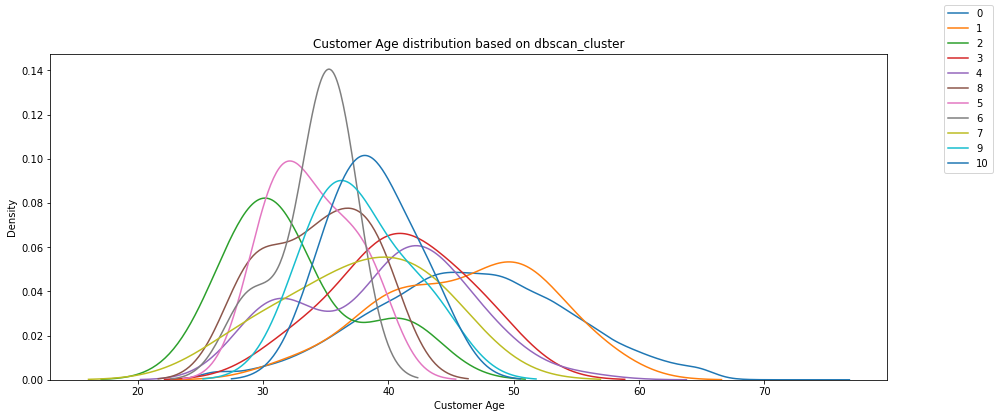

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: U

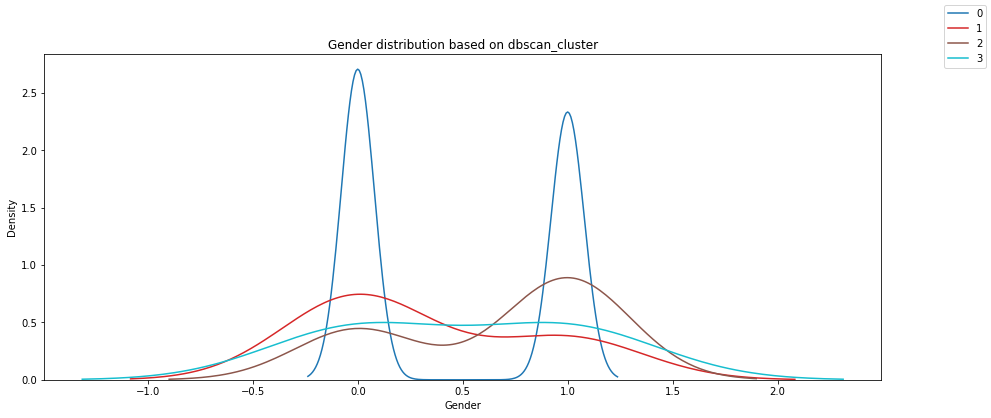

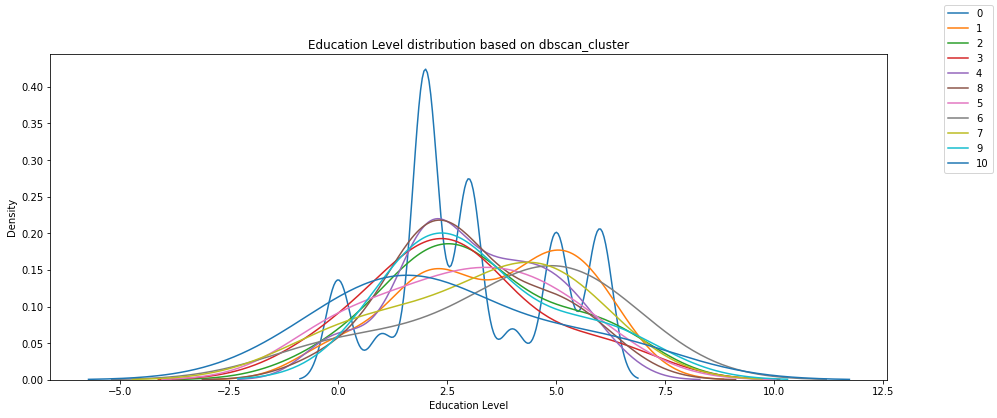

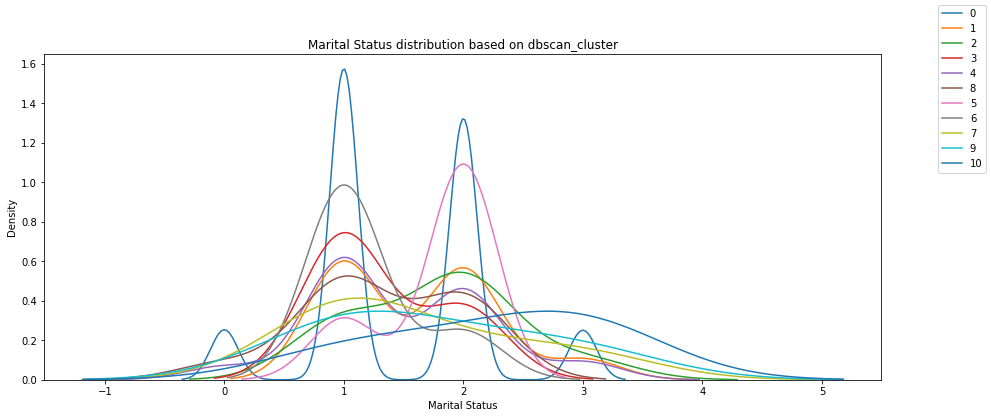

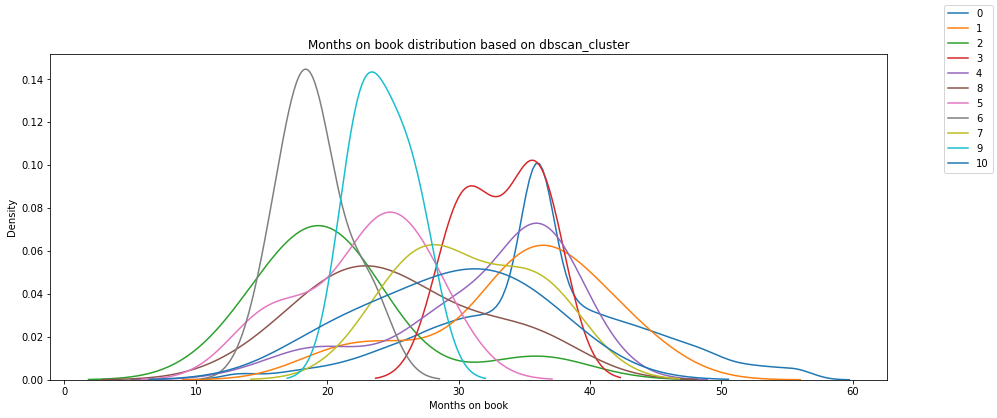

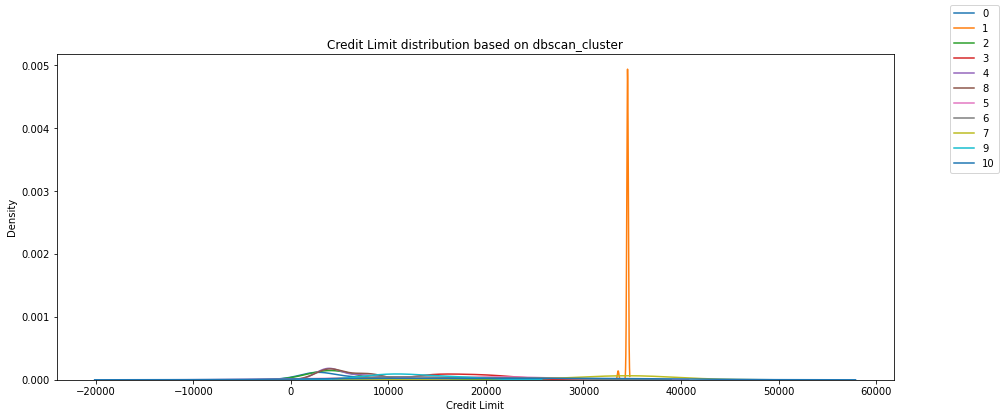

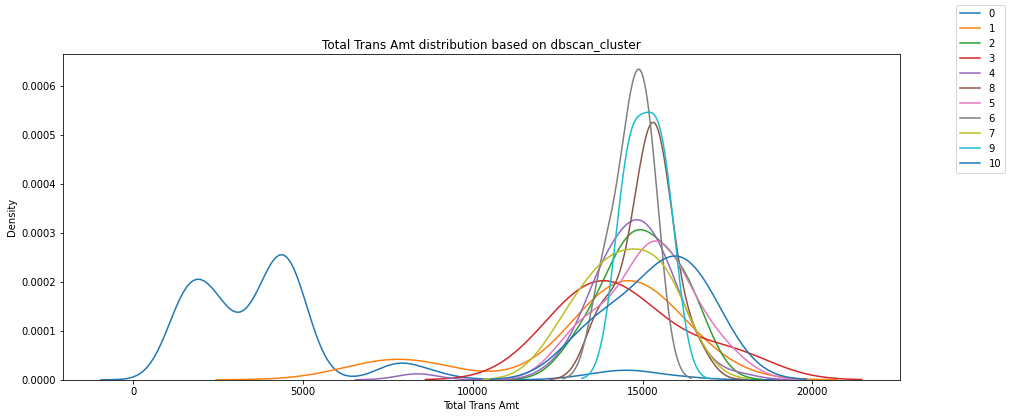

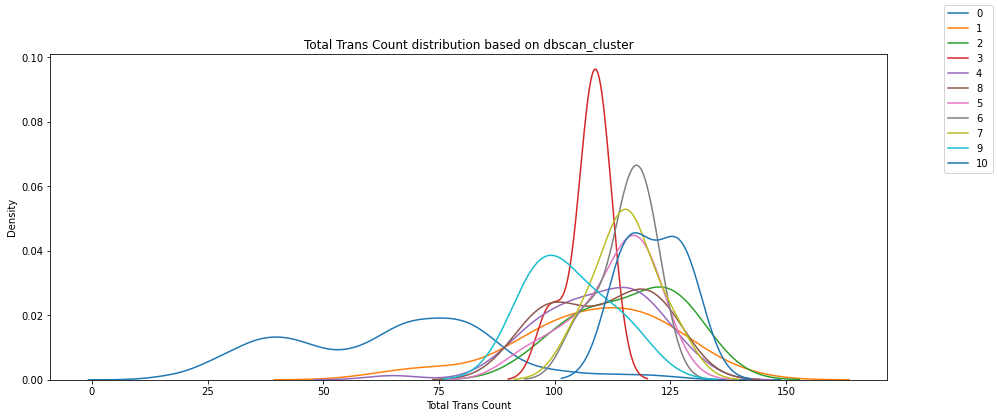

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])


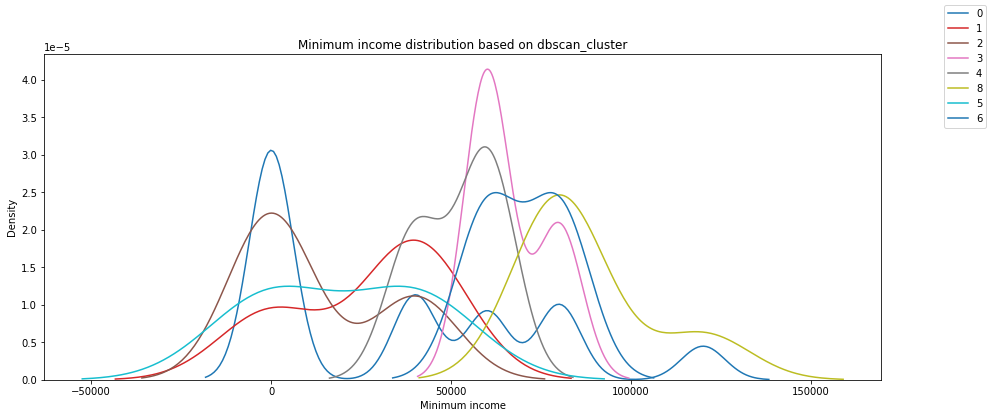

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_15860\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])


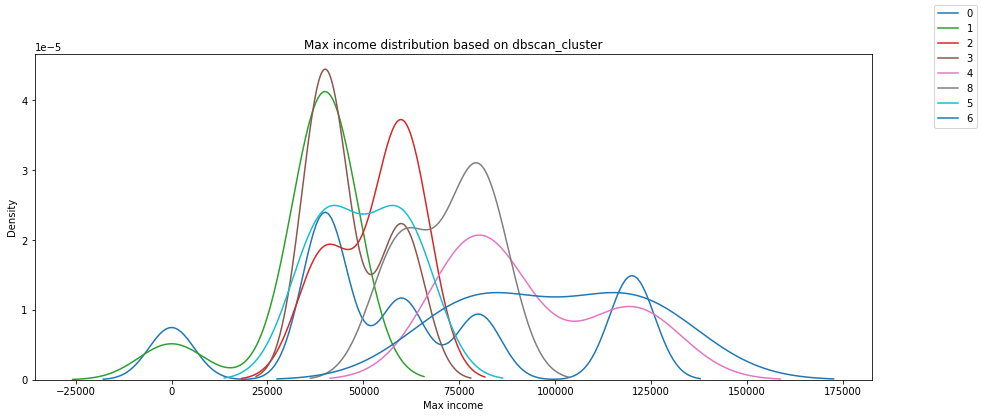

In [39]:
for feature in dbscan_data:
    if(feature == 'dbscan_cluster'):
        continue
    plot_num_cat(dbscan_data, feature, 'dbscan_cluster')

In [40]:
DBSCAN_silhouette, DBSCAN__davies_bouldin, DBSCAN__calinski_harabasz = evaluate_clustering(filtered_labels, filtered_data )
print(f'DBSCAN Silhouette score: {DBSCAN_silhouette}')
print(f'DBSCAN Davies-Bouldin Index: {DBSCAN__davies_bouldin}')
print(f'DBSCAN Calinski-Harabasz Index: {DBSCAN__calinski_harabasz}')

DBSCAN Silhouette score: 0.18710772842192594
DBSCAN Davies-Bouldin Index: 0.7798314611067642
DBSCAN Calinski-Harabasz Index: 53.40930500575324
